# Do certain amino acids receive more attention in certain positions?

In [1]:
%load_ext autoreload
%autoreload 2

from multiprocessing import Pool, cpu_count
import os
from pathlib import Path
import yaml

import numexpr
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from scripts.general import attribution, data, preprocess

numexpr.set_num_threads(cpu_count() - 2)

In [2]:
with open('experiment_config.yaml', 'r') as conf_file:
    experiment_config = yaml.load(conf_file, Loader=yaml.FullLoader)

seq_data = data.load_seq_and_abundance_data(experiment_config).drop_duplicates('swissprot_ac')
seq_data = seq_data.assign(
    abundance_bin = pd.qcut(seq_data['Median_molecules_per_cell'], q = 10, labels=range(1, 11))
)

sequence_by_id = dict(zip(seq_data['swissprot_ac'].values, seq_data['seq'].values))

In [3]:
NBINS = 50

def get_residue_attention_table_for_protein(swissprot_ac: str) -> pd.DataFrame:
    """
    Get total attention each residue receives by position bin, over all attention profiles.
    Return DataFrame with columns [residue, pos_bin, attention, profile_num, swissprot_ac]
    
    Note: relies on globals NBINS and sequence_by_id to simplify the call for pool.map()
    """
    attention_profiles, _ = attribution.load_profiles(swissprot_ac, Path('.'))
    if attention_profiles is None:
        return None, 
    
    seq = sequence_by_id[swissprot_ac]
    res_attention = [
        attribution.get_residue_attention_by_pos_bin(profile, seq, bins=NBINS).assign(profile_num = i)
        for i, profile in enumerate(attention_profiles)
    ]
    res_attention = pd.concat(res_attention, ignore_index=True).assign(swissprot_ac = swissprot_ac)
    return res_attention


prot_ids = seq_data['swissprot_ac'].values

with Pool(cpu_count() - 4) as pool:
    residue_attetntion = list(tqdm(
        pool.imap(get_residue_attention_table_for_protein, prot_ids), 
        total=len(prot_ids)
    ))
    
residue_attetntion = list(filter(lambda res: res is not None, residue_attetntion))
residue_attetntion = pd.concat(residue_attetntion, ignore_index=True)

100%|██████████| 4745/4745 [00:06<00:00, 700.38it/s]


In [4]:
residue_attetntion = pd.merge(
    residue_attetntion,
    seq_data[['swissprot_ac', 'abundance_bin']],
    on='swissprot_ac'
)

## Overview across abundance bins

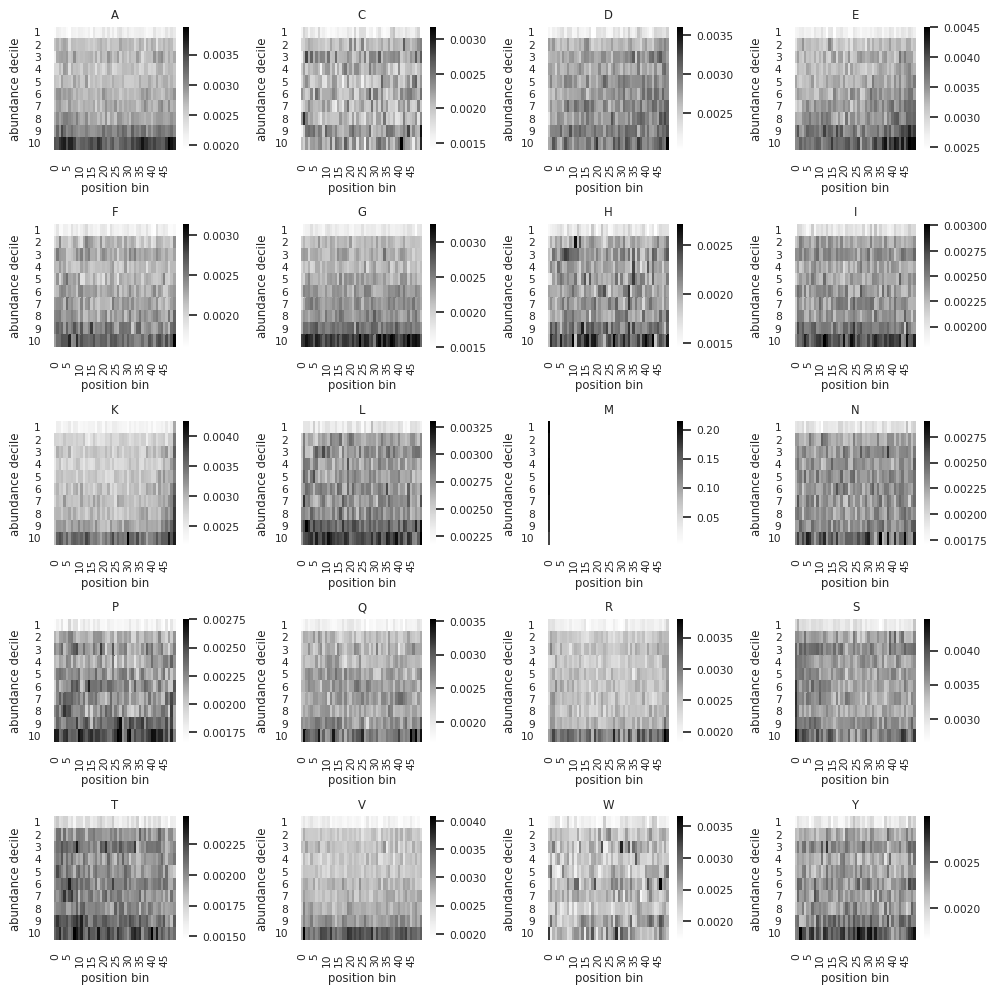

In [6]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 10)
sns.set(font_scale=0.7)

i = 1
for residue, grp_df in residue_attetntion.groupby('residue'):
    plt.subplot(5, 4, i)
    i += 1
    
    p_heatmap = sns.heatmap(
        grp_df[['abundance_bin', 'pos_bin', 'attention']]
        .pivot_table(index='abundance_bin', columns='pos_bin', values='attention', aggfunc='mean'),
        
        cmap = 'Greys'
    )

    plt.yticks(rotation=0)
    plt.xlabel('position bin')
    plt.ylabel('abundance decile')
    plt.title(residue)
    
plt.tight_layout()

## Control: Background position frequency of amino acids

In [7]:
res_counts = []

for prot_id, seq in sequence_by_id.items():
    res_count = pd.DataFrame.from_records(zip(list(seq), np.ones(len(seq), dtype=np.uint8)),
                                          columns=['residue', 'count'])
    res_count = res_count.assign(
        pos_bin = pd.cut(res_count.index, bins=NBINS, labels=False)
    )
    res_count = res_count.groupby(['residue', 'pos_bin'])['count'].sum().reset_index()
    res_count = res_count.assign(swissprot_ac = prot_id)
    res_counts.append(res_count)
    
res_counts = pd.concat(res_counts, ignore_index=True)

res_counts = pd.merge(
    res_counts,
    seq_data,
    on='swissprot_ac'
)

In [8]:
def get_residue_count_table_for_protein(swissprot_ac: str) -> pd.DataFrame:
    """
    Get total counts of each residue by position bin.
    Return DataFrame with columns [residue, pos_bin, attention, profile_num, swissprot_ac]
    
    Note: relies on globals NBINS and sequence_by_id to simplify the call for pool.map()
    """
    seq = sequence_by_id[swissprot_ac]
    res_count = attribution.get_residue_attention_by_pos_bin(np.ones(len(seq), dtype=np.uint8), seq, 
                                                             bins=NBINS)
    res_count = res_count.rename(columns={'attention': 'count'})
    return res_count.assign(swissprot_ac = swissprot_ac)


with Pool(cpu_count() - 4) as pool:
    residue_counts = list(tqdm(
        pool.imap(get_residue_count_table_for_protein, prot_ids), 
        total=len(prot_ids)
    ))
residue_counts = pd.concat(residue_counts, ignore_index=True)

residue_counts = pd.merge(
    residue_counts,
    seq_data[['swissprot_ac', 'abundance_bin']],
    on='swissprot_ac'
)

100%|██████████| 4745/4745 [00:02<00:00, 1606.67it/s]


In [9]:
background_frequencies = (
    residue_counts.groupby(['residue', 'pos_bin'])['count'].mean()
    .rename('mean_res_count').reset_index()
)

observed_distrib = (
    residue_attetntion.groupby(['residue', 'pos_bin'])['attention'].mean()
    .rename('mean_attention').reset_index()
)

obs_and_exp_res_distribs = pd.merge(
    observed_distrib,
    background_frequencies,
    on=['residue', 'pos_bin']
)

obs_and_exp_res_distribs.head(2)

,residue,pos_bin,mean_attention,mean_res_count
0,A,0,0.002687,1.311598
1,A,1,0.002874,1.411960


In [10]:
def chisq_res_counts(grp_df: pd.DataFrame):
    chisq = stats.chisquare(
        f_obs=grp_df['mean_attention'].values / grp_df['mean_attention'].values.max(),
        f_exp=grp_df['mean_res_count'].values / grp_df['mean_res_count'].values.max()
    )
    return chisq.pvalue < 0.05

obs_and_exp_res_distribs.groupby('residue').apply(chisq_res_counts)

residue
A    False
C    False
D    False
E    False
F    False
G    False
H    False
I    False
K    False
L    False
M    False
N    False
P    False
Q    False
R    False
S    False
T    False
V    False
W    False
Y    False
dtype: bool

In [11]:
any(obs_and_exp_res_distribs.groupby('residue').apply(chisq_res_counts).values)

False

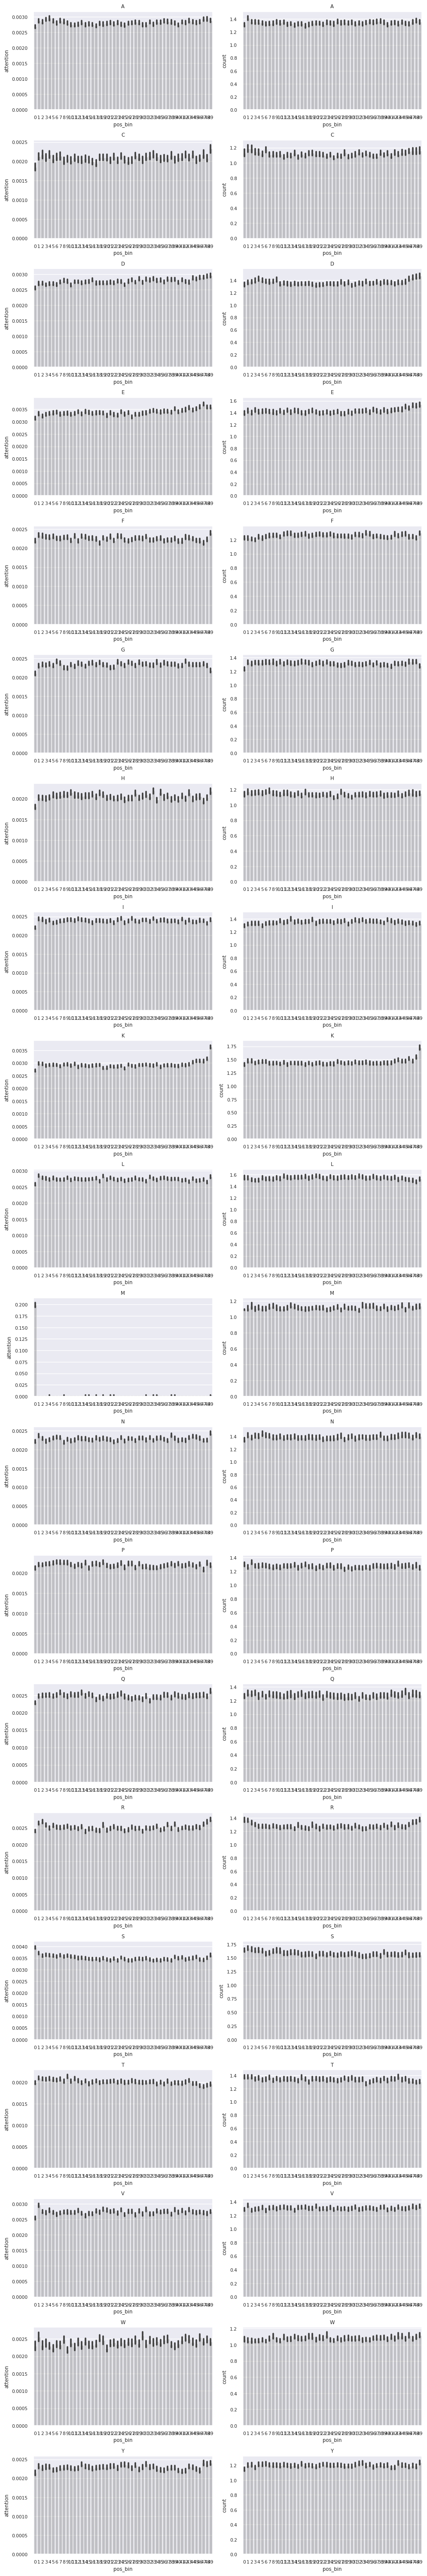

In [12]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 60)
sns.set(font_scale=0.7)

i = 1
for residue in sorted(residue_counts['residue'].unique()):
    plt.subplot(20, 2, i)
    plt.title(residue)  
    sns.barplot(
        data = residue_attetntion.query('residue == @residue'), 
        x = 'pos_bin', y = 'attention', order=range(NBINS), ci = 95,
        color='gray', alpha=0.4
    )
    
    
    plt.subplot(20, 2, i + 1)
    plt.title(residue)
    i += 2
    
    sns.barplot(
        data = residue_counts.query('residue == @residue'), 
        x = 'pos_bin', y = 'count', order=range(NBINS), ci = 95,
        color='gray', alpha=0.4
    )
    
    
plt.tight_layout()

## Conclusion


Attention to residues by position is essentially identical to the bacground amino acid frequencies.
This also explains the high attention given to initial M, since it's virtually always present.